
# Predicción de Éxito de Franquicias a escala Municipal

A éste punto del proyecto, la presente libreta busca hacer el armado del proyecto de predicción de Franquicias, estando ya en la fase de prueba de diferentes modelos y la elección del mejor

Esta es la tercer libreta, siendo las primeras dos las que abordan la "Construccion de BDD" y luego el análisis exploratorio profundo de variables.

# Limpieza de datos

Si bien ya se generó una base de datos, hay que realizarle cierta limpieza antes de someterla a análisis. Comenzamos por traer todas las librerías y dependencias para nuestro código.

In [ ]:
# Librerías y código previo para la libreta
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from scipy.stats import f_oneway, pointbiserialr, chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate
from numpy.random import seed
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from google.colab import files
import geopandas as gpd

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import Zeros, RandomNormal
from keras.optimizers import Adam
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.initializers import Zeros, RandomNormal
from keras.layers import Dense, Input, Dropout

# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
seed(1)

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Funciones complementarias
En esta sección oculta por default están algunas funciones apoyo para realizar los análisis o estandarizar la gráficas y demás configuraciones de apoyo. Así que hay que correr esta celda.

In [ ]:
def data_exploration(data:pd.DataFrame)-> pd.DataFrame:
  exploration = pd.DataFrame(columns = data.columns,
                           index=['type','null_counts','uniques'])
  # shape of dataframe
  shape = data.shape
  #data['shape rows'] = shape[0]
  # num of nulls per column
  null_counts = data.isnull().sum()
  exploration.loc['null_counts'] = null_counts
  # categorical or numeric data columns
  cat_cols = [col for col in data.columns if col not in data.describe().columns]
  num_cols = data._get_numeric_data().columns
  exploration.loc['type', cat_cols] = 'categorical'
  exploration.loc['type', num_cols] = 'numeric'
  # unique values
  exploration.loc['uniques', data.nunique().index] = data.nunique().values

  return exploration

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

<ipython-input-6-1e797e217525>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Carga de datos

Cargamos las bases de datos, usaremos dos en principio debido a que una recopila información total de *Servicios de preparación de alimentos y bebidas alcohólicas y no alcohólicas* y la otra tiene el desglose por la clase al que pertence cada servicio.

In [ ]:
# Path a nuestra base municipal, ésto puede variar si no estas correindo éste codigo en su lugar original
path_municipal = 'BDD Municipal.xlsx'

# Leemos el archivo
BDD_Municipal = pd.read_excel(path_municipal)

# Mostramos las columnas comprometidas en la BDD (Las dos en principio tienen las mismas columnas)
BDD_Municipal.head(2)

,Clave Estado,Estado,Clave Municipio,Municipio,Población Total,Población Adulta,Densidad de Población,Robo a negocios,Robo en espacio público,Robo en calles,...,Gobierno,Oficinas,Cines,CentroCom,Actividad económica,Unidades económicas,Gasto de Inmuebles y Muebles ($M),Gastos ($M),Ingresos ($M),Utilidad p/UE ($M)
0,1,aguascalientes,1,aguascalientes,948990,622235,805.525594,1881.0,1.0,1864.0,...,328,3,9,82,Total municipal,40547.0,41387.091,290002.201,401843.165,2.758304
1,1,aguascalientes,2,asientos,51536,29965,93.870884,17.0,0.0,12.0,...,14,0,0,0,Total municipal,845.0,240.572,3183.365,8297.457,6.052180


Realizamos una limpieza superficial para no tener errores o problemas posteriores

Usando la función **data_exploration** para obtener un análisis de todas las columnas en el DataFrame, esta función brinda información como el tipo de datos presentes en cada columna, el número de valores nulos y el número de valores únicos. La función data_exploration() devulve un DataFrame con los datos antes mencionados.

In [ ]:
data_exploration(BDD_Municipal)

,Clave Estado,Estado,Clave Municipio,Municipio,Población Total,Población Adulta,Densidad de Población,Robo a negocios,Robo en espacio público,Robo en calles,...,Gobierno,Oficinas,Cines,CentroCom,Actividad económica,Unidades económicas,Gasto de Inmuebles y Muebles ($M),Gastos ($M),Ingresos ($M),Utilidad p/UE ($M)
type,numeric,categorical,numeric,categorical,numeric,numeric,numeric,numeric,numeric,numeric,...,numeric,numeric,numeric,numeric,categorical,numeric,numeric,numeric,numeric,numeric
null_counts,0,0,0,0,0,0,0,6,6,6,...,0,0,0,0,4,4,6,6,6,6
uniques,32,32,570,2326,2402,2351,2469,209,54,165,...,200,21,23,28,1,1366,1998,2452,2456,2462


Eliminamos los nulos que hay en las columnas objetivo, que corresponden a la utilidad (que va de la mano a ingresos y gastos). En la libreta anterior puedes observar cuales son éstos nulos y como dato, son poblaciones muy pequeñas (alrededor de 1000 personas) y puiede que no se haya tenido permiso a estos datos de forma pública.

In [ ]:
columnas_con_nulos = ['Gastos ($M)', 'Ingresos ($M)', 'Utilidad p/UE ($M)']
BDD_Municipal.dropna(subset=columnas_con_nulos, inplace=True)

In [ ]:
# Mostrar qué columnas tienen valores nulos
null_columns = BDD_Municipal.columns[BDD_Municipal.isnull().any()].tolist()

print("Columnas con valores nulos:")
print(null_columns)


In [ ]:
# Revisamos que municipio no tienen ésta información
Colms_Revisar = ['Robo a negocios']
df_nulos = BDD_Municipal[BDD_Municipal[Colms_Revisar].isnull().any(axis=1)]
#df_nulos.head(-3)
print('Municipios sin información:',len(df_nulos['Municipio'].unique()))
df_nulos['Municipio'].unique()

Municipios sin información: 2


array(['coatetelco', 'xoxocotla'], dtype=object)

Al no tener consistencia en las demás columnas de éstas características, se tomó la decisión de eliminar éstas filas por fines estadísticos. Posteriormente ser pueden recuperar ya para la parte del modelo.

In [ ]:
columnas_con_nulos = ['Robo a negocios']
BDD_Municipal.dropna(subset=columnas_con_nulos, inplace=True)

Revisamos de nuevo

In [ ]:
data_exploration(BDD_Municipal)

,Clave Estado,Estado,Clave Municipio,Municipio,Población Total,Población Adulta,Densidad de Población,Robo a negocios,Robo en espacio público,Robo en calles,...,Gobierno,Oficinas,Cines,CentroCom,Actividad económica,Unidades económicas,Gasto de Inmuebles y Muebles ($M),Gastos ($M),Ingresos ($M),Utilidad p/UE ($M)
type,numeric,categorical,numeric,categorical,numeric,numeric,numeric,numeric,numeric,numeric,...,numeric,numeric,numeric,numeric,categorical,numeric,numeric,numeric,numeric,numeric
null_counts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
uniques,32,32,570,2321,2394,2343,2461,209,54,165,...,200,21,23,28,1,1365,1996,2450,2454,2460


Como paso extra, para esta base de datos la actividad económica no es relevante puesto que tenemos el total municipal, así que la eliminamos

In [ ]:
BDD_Municipal= BDD_Municipal.drop(columns=['Actividad económica'])
BDD_Municipal.head(-5)

## Codificación de variables cualitativas

hacemos un pequeño diccionarios para "encriptar" las variables cualitativas y separamos un dataframe para usar las puras claves de estado-municipio y en caso de ser necesario consultar los nombres del estado o municipio considerado.

In [ ]:
codificacion = {
    "Tipo de población": {
        "Rural": 1,
        "En Transición": 2,
        "Semi-urbano": 3,
        "Urbano": 4,
        "Semi-metrópoli": 5,
        "Metrópoli": 6
    }
}
# 'Semi-metrópoli', 'Urbano', 'Semi-urbano', 'En Transición', 'Metrópoli', 'Rural'
BDD_Municipal["Tipo de población"] = BDD_Municipal["Tipo de población"].map(codificacion["Tipo de población"])

## Keys de estado y municipio

In [ ]:
# Crear un nuevo DataFrame con las columnas de clave de municipio y estado, estado y municipio
Edo_Mun_Keys = BDD_Municipal[['Clave Estado', 'Estado', 'Clave Municipio', 'Municipio']].copy()

# Eliminar las columnas de los nombres de estado y municipio del DataFrame original
BDD_Municipal = BDD_Municipal.drop(columns=['Estado', 'Municipio'])

In [ ]:
# Descargamos la base de datos resultantes
Edo_Mun_Keys.to_excel('Claves Edo - Mun.xlsx', index=False)
# Descargar el archivo Excel en el local
files.download('Claves Edo - Mun.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## BDD Limpia

In [ ]:
# Descargamos la base de datos resultante
BDD_Municipal.to_excel('BDD_Clean.xlsx', index=False)
# Descargar el archivo Excel en el local
files.download('BDD_Clean.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Construcción del modelo

Para obtener un modelo evaluaremos 3 enfoques:

*   **Enfoque global**: Usar las características en total para la predicción de la Utilidad para luego crear con los pesos del modelo el porcentaje de éxito.

*   **Por dimensión**: Dividimos las características por dimensión Urbana para crear una calificación por cada una, al final tendremos una calificación promedio de las otras

*   **Por Cluster**: En este caso el enfoque es aplicar el modelo por cada tipo de mercado, dado por la clusterización realizada a nivel municipio. A su vez, podemos tomar ésto en los clusters en general y por dimensión urbana.

## Creación de Datasets de prueba

En ésta parte, una vez ya analizadas las diferentes formas en las que podemos hacer ingeniería de características para selección de variables, procedemos a crear diferentes datasets para ponerlos a prueba con nuestros modelos.

### Funciones de apoyo

In [ ]:

def outliers_detection(dataset, threshold=3):
  total_outliners = 0
  outliers = pd.DataFrame()
  #dataset = dataset.drop('age', axis=1)
  for column in dataset.columns:
    if dataset[column].dtype == 'object':
      # Si la columna es categórica, no se detectan valores atípicos
      continue
    series = dataset[column]
    mean = series.mean()
    deviation = series.std()
    upper_threshold = mean + (threshold * deviation)
    lower_threshold = mean - (threshold * deviation)
    outliers_column = series[(series > upper_threshold) | (series < lower_threshold)]
    outliers[column] = outliers_column
    total_outliners += len(outliers_column)

  return outliers, total_outliners

def variance_threshold_analysis(data: pd.DataFrame, threshold: float = 0.8) -> pd.DataFrame:
    # Crear el selector de VarianceThreshold
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))

    # Ajustar el selector al data y transformar los datos
    sel.fit(data)

    # Identificar las columnas que se deberían eliminar
    to_remove = data.columns[~sel.get_support()]

    # Eliminar las columnas del DataFrame original
    data_reduced = data.loc[:, sel.get_support()]

    return data_reduced, to_remove


# Método 1: Backward Elimination
def backward_elimination(X, y, significance_level=0.05):
    X_with_constant = sm.add_constant(X)
    model = sm.OLS(y, X_with_constant).fit()
    while max(model.pvalues) > significance_level:
        excluded_feature = model.pvalues.idxmax()
        X_with_constant = X_with_constant.drop(columns=[excluded_feature])
        model = sm.OLS(y, X_with_constant).fit()
    selected_features = X_with_constant.columns.tolist()
    if 'const' in selected_features:
        selected_features.remove('const')
    return selected_features

Revisamos cuantitativamente las relaciones entre variables, usaremos diferentes criterios.

### Correlación

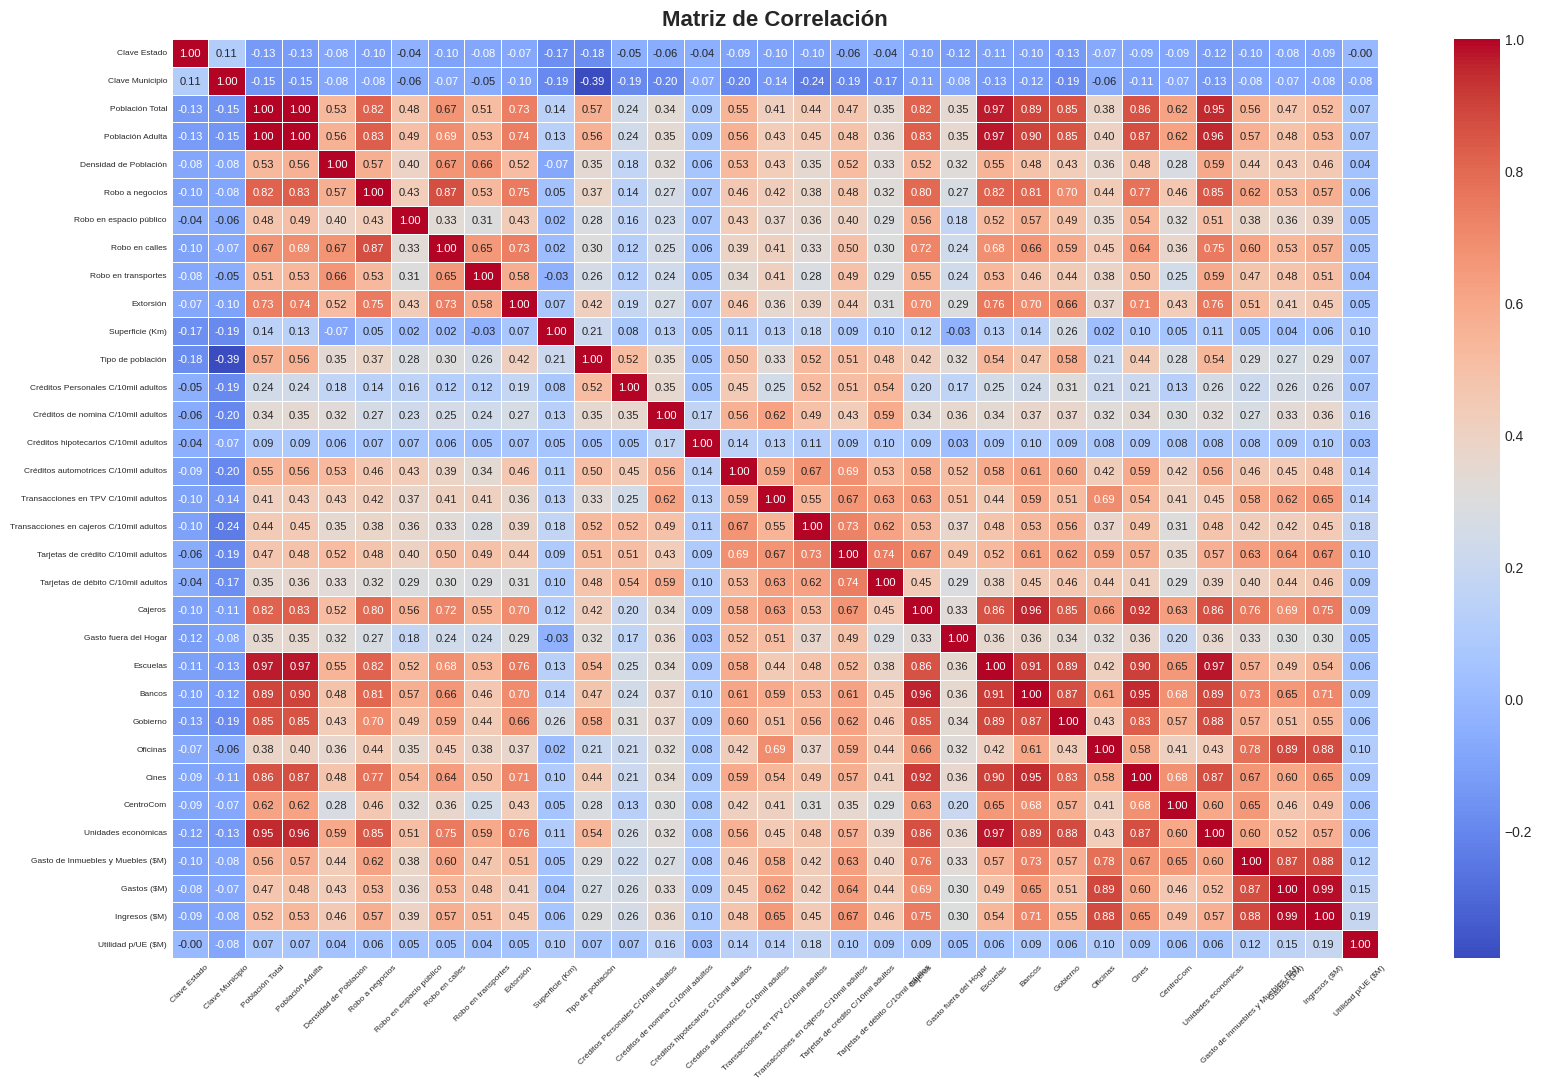

In [ ]:
# Supongamos que X es tu DataFrame
correlation_matrix = BDD_Municipal.corr()

# Visualizamos la matriz de correlación en un heat map
plt.figure(figsize=(17, 11))  # Aumentar el tamaño de la figura
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})  # Reducir el tamaño de la fuente de las anotaciones

# Ajustar el tamaño de la fuente de las etiquetas de los ejes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=6, rotation=45)  # Rotar las etiquetas de los ejes para mejorar la legibilidad
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=6, rotation=0)

plt.ylim(len(correlation_matrix), 0)  # Ajustar límites de los ejes correctamente
plt.xlim(0, len(correlation_matrix))
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
# Identificamos las variables altamente correlacionadas
threshold = 0.8
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)

# Mostrar las variables altamente correlacionadas
print("Variables altamente correlacionadas (correlación > 0.8 o < -0.8):")
for pair in highly_correlated_pairs:
    print(f"{pair[0]} y {pair[1]}: {pair[2]:.2f}")

# Crear un DataFrame para una visualización más estructurada
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Variable 1", "Variable 2", "Correlación"])

Construcción de Dataset basado en la decisión de correlación

In [ ]:
variables_a_eliminar = ['Población Adulta', 'Robo en calles', 'Escuelas', 'Bancos', 'Cines', 'Unidades económicas', 'Gastos ($M)', 'Ingresos ($M)', 'Superficie (Km)', 'Gasto fuera del Hogar']
#.drop(columns=['Gasto fuera del Hogar', 'Ingresos ($M)', 'Gastos ($M)', 'Superficie (Km)'])
Dataset_Correlacion_A = BDD_Municipal.drop(columns=variables_a_eliminar)

Dataset_Correlacion_A.head()

### ✋ *Decisiones sobre el modelo*

Eliminaremos la variable "Gasto fuera del hogar" debido a la gran cantidad de nulos que presenta y dada la correlación y el análisis de dispersión, no representa una variable primordial estadísticamente hablando. Se buscara usarla para otros análisis.

Vamos a quitar también "Ingresos" y "Gastos" también por su relación directa con la utilidad y darle ponderación a la data que concierne al municipio.

In [ ]:
BDD_Municipal_Elim = BDD_Municipal.copy()
#BDD_Municipal_Elim = BDD_Municipal_Elim.drop(columns=['Gasto fuera del Hogar', 'Superficie (Km)'])
BDD_Municipal_Elim = BDD_Municipal_Elim.drop(columns=['Gasto fuera del Hogar', 'Ingresos ($M)', 'Gastos ($M)', 'Superficie (Km)'])

### Variance Inflation Factor (VIF)

El VIF (Variance Inflation Factor) es una medida estadística que se utiliza para detectar la multicolinealidad entre variables predictoras en un modelo de regresión. La multicolinealidad ocurre cuando dos o más variables predictoras están altamente correlacionadas entre sí, lo cual puede causar problemas en el modelo de regresión, como coeficientes estimados imprecisos o inestables.

El fundamento estadístico del VIF se basa en la idea de que cada variable predictora en un modelo de regresión lineal múltiple puede expresarse como una combinación lineal de las demás variables predictoras. Si una variable predictora es altamente correlacionada con otras variables en el modelo, su varianza (y por lo tanto la varianza de su estimación) se infla, lo que se refleja en un alto VIF

Primero normalizamos el conjunto de datos y luego calculamos el variance inflation factor

In [ ]:
# Estandarizamos los datos
scaler = StandardScaler()
BDD_Municipal_Elim_scaled = scaler.fit_transform(BDD_Municipal_Elim)

# Convertimos el array escalado de vuelta a un DataFrame
BDD_Municipal_Elim_scaled_df = pd.DataFrame(BDD_Municipal_Elim_scaled, columns=BDD_Municipal_Elim.columns)

# Calculamos el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = BDD_Municipal_Elim_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(BDD_Municipal_Elim_scaled_df.values, i) for i in range(BDD_Municipal_Elim_scaled_df.shape[1])]

# Imprimimos los resultados del VIF
print("\nPuntuaciones VIF para todas las variables:")
vif_data

In [ ]:
# Identificamos las variables con VIF > 10
high_vif = vif_data[vif_data["VIF"] > 10]

# Mostramos las variables eliminadas y su puntuación VIF
print("\nVariables eliminadas debido a VIF alto (VIF > 10):")
high_vif


Variables eliminadas debido a VIF alto (VIF > 10):


,Variable,VIF
2,Población Total,748.680687
3,Población Adulta,919.158695
19,Cajeros,29.375467
20,Escuelas,68.658854
21,Bancos,54.724946
24,Cines,14.111540
26,Unidades económicas,37.599010


Construcción de Dataset basado en la decisión de correlación

In [ ]:
# Eliminamos variables con VIF > 10 utilizando sus nombres
variables_to_keep = vif_data[vif_data["VIF"] <= 10]["Variable"]
Dataset_VIF = BDD_Municipal_Elim[variables_to_keep]

# Mostrar el DataFrame reducido
print("\nDataFrame reducido:")
Dataset_VIF.head(3)

### Backward Elimination (Eliminación hacia atrás)

En este método, comenzamos con un modelo que incluye todas las características disponibles. Luego, ajustamos el modelo y evaluamos la importancia de cada característica utilizando criterios como los p-valores en modelos lineales. La característica menos significativa, según el criterio seleccionado, se elimina del modelo en cada iteración. Este proceso se repite iterativamente hasta que se cumple un criterio de parada, como un rendimiento del modelo que no mejora significativamente o se alcanza un número deseado de características.

Preparación de los datos para hacer la eliminación

In [ ]:
# Esta copia sera clave para que una vez hagamos la selección de características
# Nos podamos traer la BDD original después de las decisiones sobre la data
data_OG = BDD_Municipal_Elim.copy()
# Esta copia es la que usaremos para la normalización y selección de caracteristicas
data = BDD_Municipal_Elim.copy()

# Normalización de características numéricas
numeric_features = BDD_Municipal_Elim.columns
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Variable objetivo
y_ = data['Utilidad p/UE ($M)']
X_ = data.drop(['Clave Estado', 'Clave Municipio', 'Utilidad p/UE ($M)'], axis=1)

In [ ]:
# Backward Elimination
selected_features_be = backward_elimination(X_, y_)
removed_features_be = list(set(X_.columns) - set(selected_features_be))
# Construcción de Dataset basado en la decisión de correlación
#Dataset_Backward_Elimination = data_OG[['Clave Estado', 'Clave Municipio'] + selected_features_be + ['Utilidad p/UE ($M)']]
Dataset_Backward_Elimination = data_OG[selected_features_be + ['Utilidad p/UE ($M)']]

print("Dimensión Original")
print(BDD_Municipal_Elim.shape)
print("Dimensión Nueva")
print(Dataset_Backward_Elimination.shape)
print("Columnas eliminadas por Backward Elimination:")
removed_features_be

### Recursive Feature Elimination (RFE - Eliminación recursiva de características)

Similar a la eliminación hacia atrás, RFE también busca reducir el número de características en un modelo. Sin embargo, en lugar de eliminar características una a una, RFE evalúa la importancia relativa de cada característica según algún criterio definido por el modelo, como los coeficientes en modelos lineales o la importancia de características en modelos basados en árboles. Las características menos importantes se eliminan en grupos en cada iteración, basándose en su contribución relativa al modelo ajustado. Este proceso continúa hasta que se alcanza el número deseado de características o se cumple un criterio de parada predefinido.


Prácticamente funciona como el anterior, solo que aquí podemos elegir directamente cuantas características mantener

In [ ]:
# Recursive Feature Elimination (RFE)

# Aquí hay que elegir cuantas columnas queremos, como prueba
# probemos con elegir las mismas que Backward Elimination
Features_a_elegir = 12

model_lr = LinearRegression()
rfe = RFE(model_lr, n_features_to_select=Features_a_elegir)
fit = rfe.fit(X_, y_)
selected_features_rfe = X_.columns[fit.support_].tolist()
removed_features_rfe = list(set(X_.columns) - set(selected_features_rfe))
#Dataset_RFE = data_OG[['Clave Estado', 'Clave Municipio'] + selected_features_rfe + ['Utilidad p/UE ($M)']]
Dataset_RFE = data_OG[selected_features_rfe + ['Utilidad p/UE ($M)']]

print("Dimensión Original")
print(BDD_Municipal_Elim.shape)
print("Dimensión Nueva")
print(Dataset_RFE.shape)
print("Columnas eliminadas por RFE:")
removed_features_rfe

### Random Forest

El algoritmo de Random Forest utiliza múltiples árboles de decisión para mejorar la precisión del modelo y reducir el sobreajuste. Durante la construcción de cada árbol en el bosque, se seleccionan muestras aleatorias del conjunto de datos y características aleatorias en cada división de nodo. Durante este proceso, se evalúa la importancia de cada característica según su contribución al criterio de división del árbol (como la ganancia de información en árboles de decisión). Esta importancia se calcula automáticamente durante la construcción del bosque, lo que permite obtener una visión clara de qué características son más relevantes para la predicción final del modelo.

In [ ]:
# Método 3: Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_, y_)
selector = SelectFromModel(model_rf, prefit=True)
selected_features_rf = X_.columns[selector.get_support()].tolist()
removed_features_rf = list(set(X_.columns) - set(selected_features_rf))
#Dataset_Random_Forest = data_OG[['Clave Estado', 'Clave Municipio'] + selected_features_rf + ['Utilidad p/UE ($M)']]
Dataset_Random_Forest = data_OG[selected_features_rf + ['Utilidad p/UE ($M)']]


print("Dimensión Original")
print(BDD_Municipal_Elim.shape)
print("Dimensión Nueva")
print(Dataset_Random_Forest.shape)
print("Columnas eliminadas por RF:")
removed_features_rf

## Desarrollo previo

Como primera impresión probaremos las técnicas del modelo con el dataframe completo (Sin el de gasto fuera del hogar debido a la falta de la mitad de municipios con información)

In [ ]:
data = BDD_Municipal_Elim.copy()

In [ ]:
data.head()

Hacemos la preparación de datos para los modelos. Buscamos normalizar los datos, podemos hacer con la normalización automática de python o hacerla manual con lo siguiente:

$$x_{i,norm} = \dfrac{x_{i}-\mu}{\sigma}$$
    
$$y_{i,norm} = \dfrac{y_{i}-\mu}{\sigma}$$

In [ ]:
# Renombrar la columna objetivo para facilitar el acceso
data.rename(columns={"Utilidad p/UE ($M)": "Utilidad"}, inplace=True)

# Seleccionar las características (X) y el objetivo (y)
X = data.drop(columns=["Utilidad"])
y = data["Utilidad"]

# División de los datos en conjunto de entrenamiento y prueba
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización Automática
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train_)
#X_test = scaler.transform(X_test_)

# Normalización Manual
media=X_train_.mean() #media datos de entrenamiento
std=X_train_.std() #desviacion estandar de entrenamiento

X_train=(X_train_-media)/std
X_test=(X_test_-media)/std


### Modelos

Probaremos diferentes modelos para además de compararlos, generar una calificación conjunta.

#### Lasso

In [ ]:

# Definición del modelo Lasso
lasso = Lasso()

# Definición de la rejilla de parámetros para la búsqueda
param_grid = {
    'alpha': np.logspace(-4, 4, 50)  # Valores de alpha en escala logarítmica
}

# Configuración de GridSearchCV para optimizar alpha
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_lasso = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_train = best_lasso.predict(X_train)
y_pred_test_Lasso = best_lasso.predict(X_test)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.273e+03, tolerance: 5.120e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e+04, tolerance: 5.615e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.406e+03, tolerance: 2.791e

In [ ]:
# Calcular el error cuadrático medio en el conjunto de prueba
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_Lasso))

print(f"Mejor valor de alpha: {grid_search.best_params_['alpha']}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

#### Decision tree

Dumb desicion tree

In [ ]:
# We create the decision tree model and fit the model with training data
model_DT = DecisionTreeRegressor()

model_DT.fit(X_train, y_train)
y_pred_DT = model_DT.predict(X_train)

y_pred_test = model_DT.predict(X_test)
# Calcular el error cuadrático medio en el conjunto de prueba
pred_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test RMSE: {pred_test_rmse}")

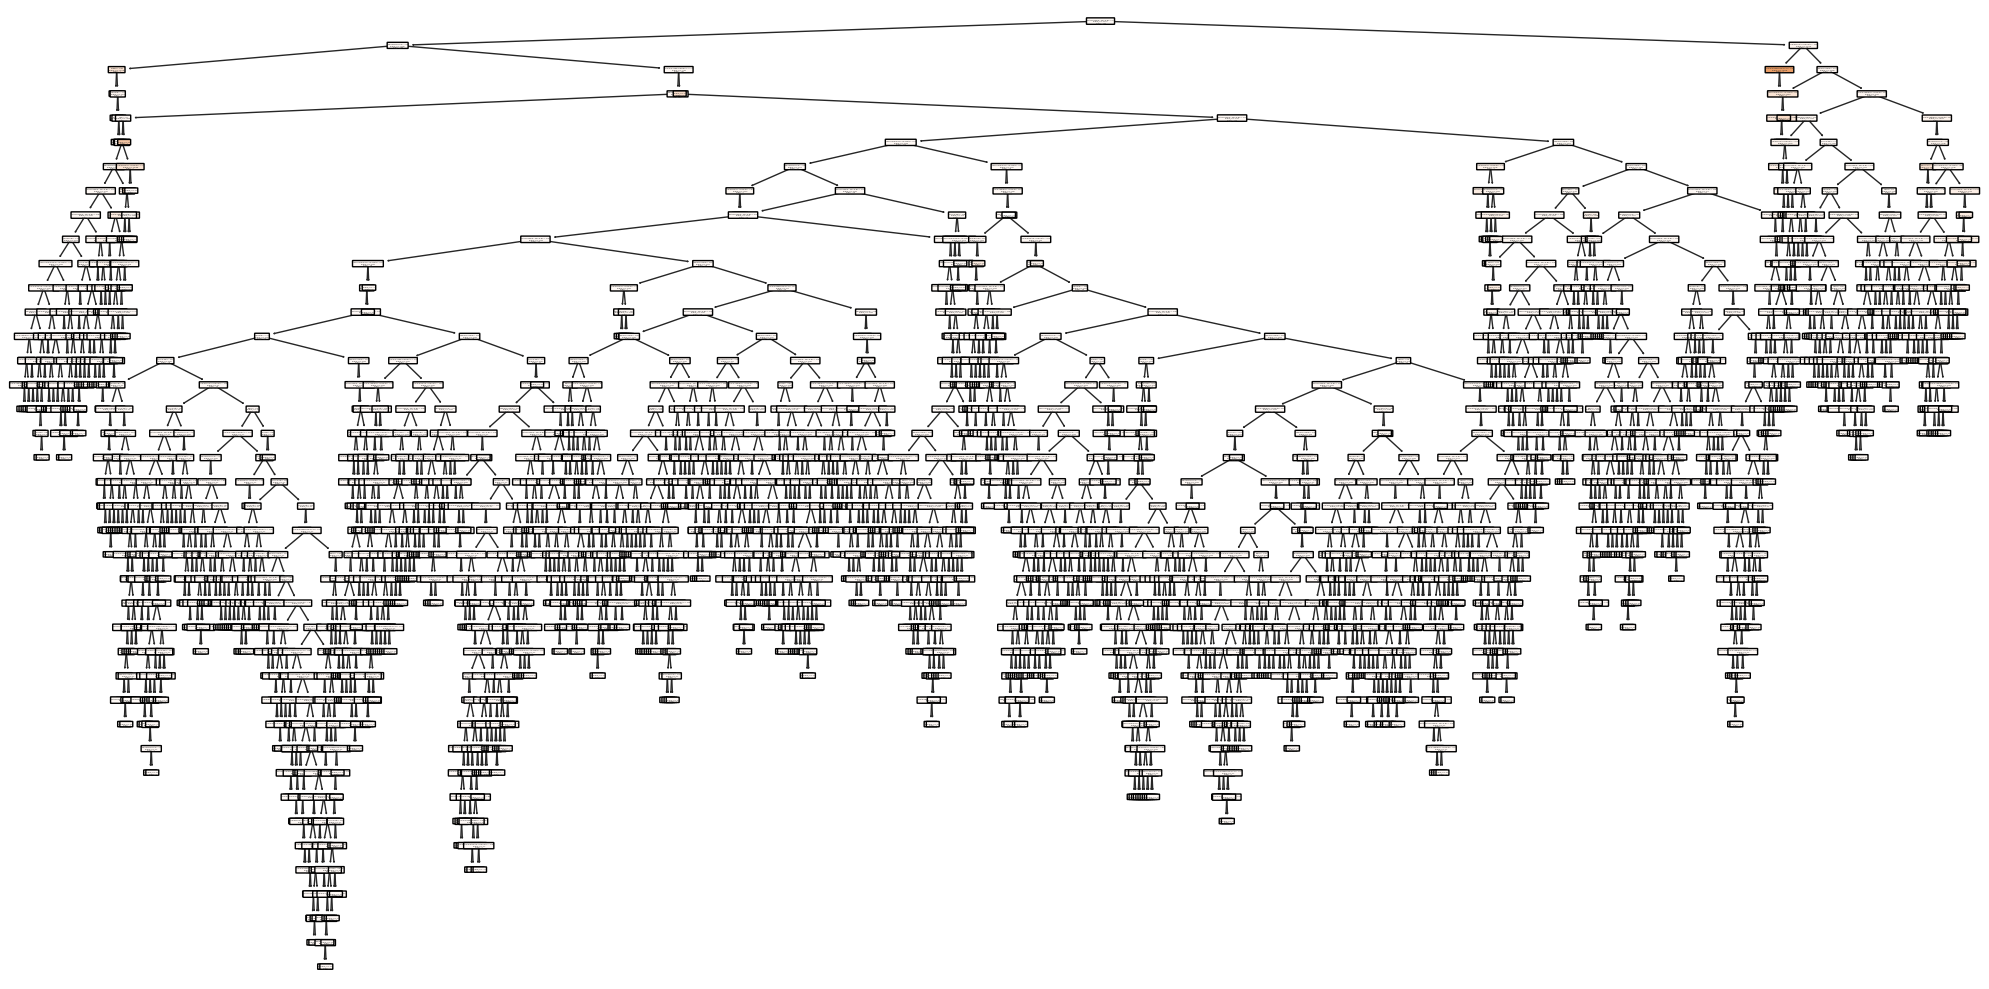

In [ ]:
# Visualizar el árbol de decisión
# Visualizar la importancia de las características
feature_names = list(X.columns)
importances = model_DT.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,10))
plot_tree(model_DT, feature_names=feature_names, filled=True, rounded=True)
plt.show()

Optimizamos los parámetros

In [ ]:
# Supongamos que ya tienes X_train_scaled, X_test_scaled, y_train, y_test

# Definir el modelo de árbol de decisión para regresión
model_DTR = DecisionTreeRegressor(random_state=42)

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model_DTR, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model_DTR = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_train = best_model_DTR.predict(X_train)
y_pred_test_DT = best_model_DTR.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_DT))

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [ ]:
# Visualizar la importancia de las características
feature_names = list(X.columns)
importances = best_model_DTR.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

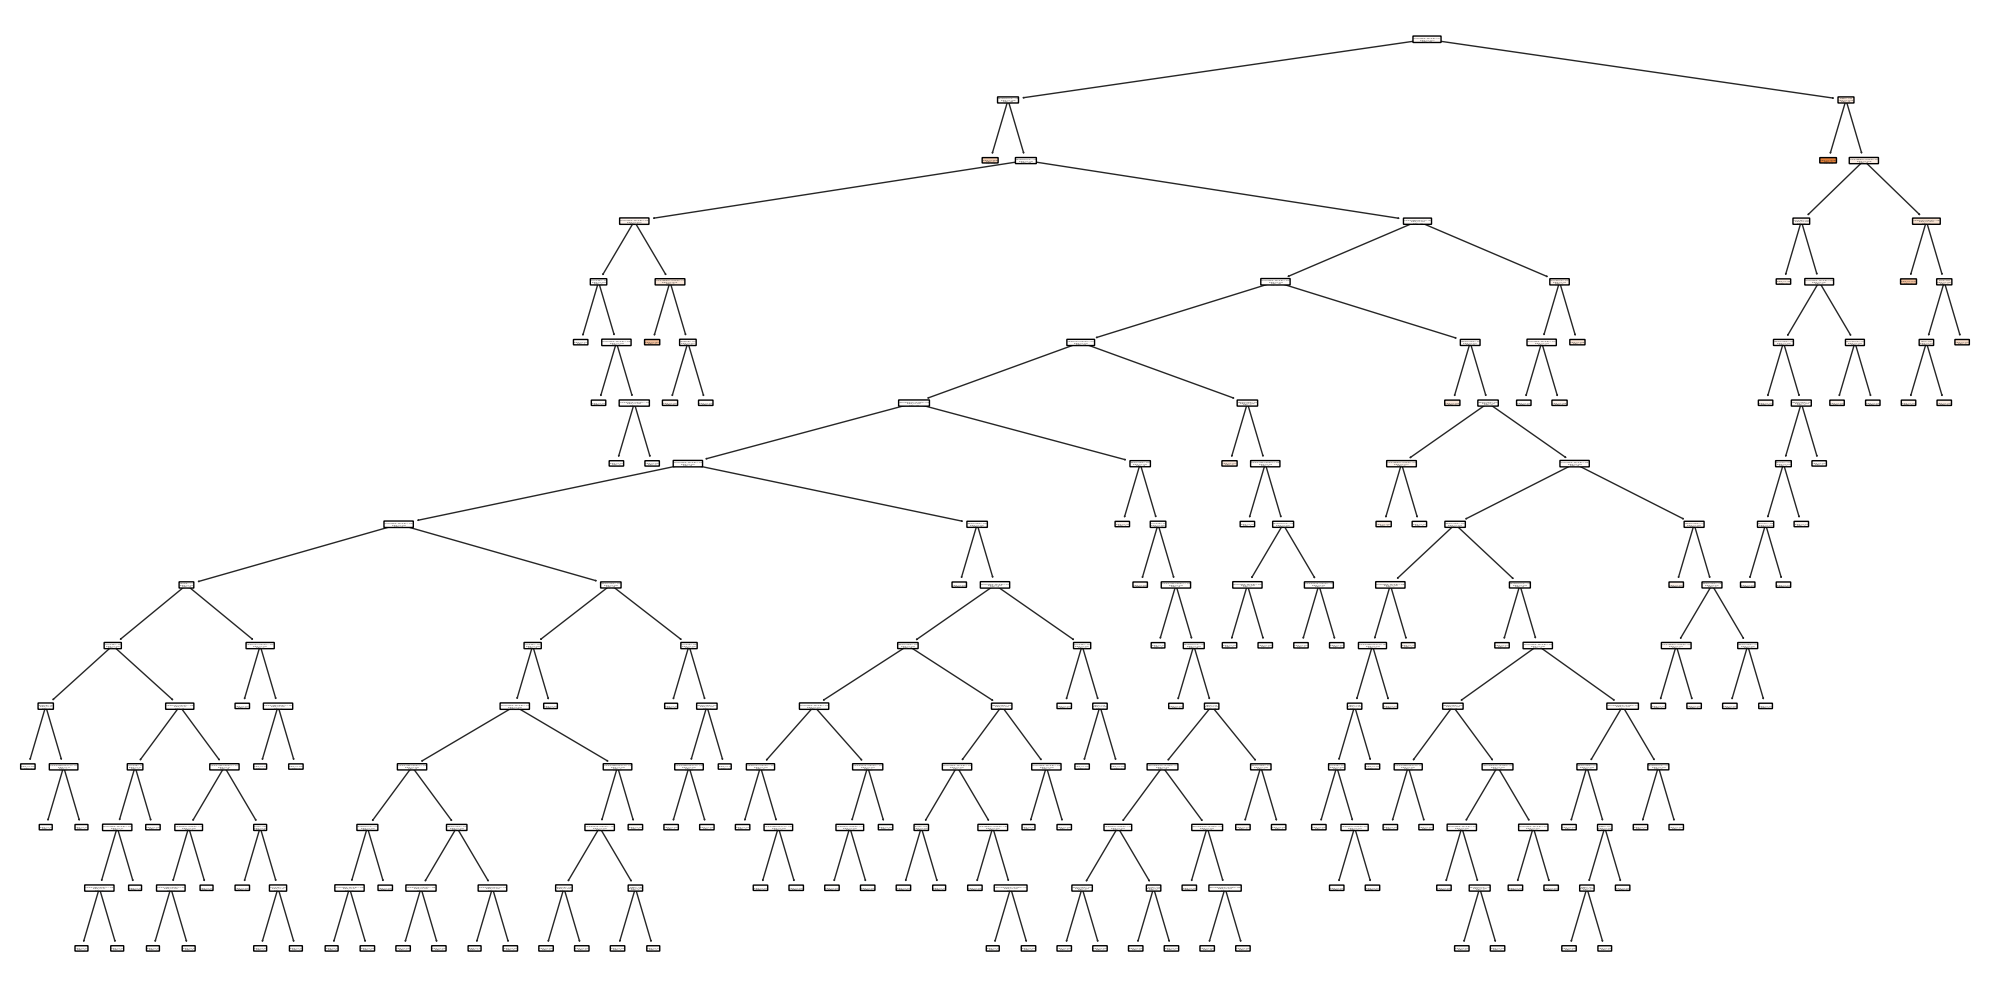

In [ ]:
# Visualizar el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(best_model_DTR, feature_names=feature_names, filled=True, rounded=True)
plt.show()

#### RandomForest

In [ ]:
# Supongamos que ya tienes X_train_scaled, X_test_scaled, y_train, y_test

# Definir el modelo de Random Forest para regresión
model_RFR = RandomForestRegressor(random_state=42)

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model_RFR, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model_RFR = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_train = best_model_RFR.predict(X_train)
y_pred_test_RF = best_model_RFR.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
# Calcular el error cuadrático medio en el conjunto de prueba
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_RF))

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [ ]:
# Visualizar la importancia de las características
feature_names = list(X.columns)
importances = best_model_RFR.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# Definir el modelo ElasticNet
model_elasticnet = ElasticNet(random_state=42)

# Definir la rejilla de parámetros para la búsqueda
param_grid_elasticnet = {
    'alpha': np.logspace(-4, 2, 10),  # Valores de alpha en escala logarítmica
    'l1_ratio': [0.2, 0.4, 0.6, 0.8]  # Proporción de regularización L1 (0 a 1)
}

# Configurar GridSearchCV
grid_search_elasticnet = GridSearchCV(estimator=model_elasticnet,
                                      param_grid=param_grid_elasticnet,
                                      cv=10,
                                      scoring='neg_mean_squared_error',
                                      verbose=1)

# Ajustar el modelo a los datos de entrenamiento
grid_search_elasticnet.fit(X_train, y_train)

# Obtener el mejor modelo
best_model_elasticnet = grid_search_elasticnet.best_estimator_

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e+04, tolerance: 5.120e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e+04, tolerance: 5.615e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+04, tolerance: 2.791e

In [ ]:
# Hacer predicciones con el mejor modelo
y_pred_train_elasticnet = best_model_elasticnet.predict(X_train)
y_pred_test_elasticnet = best_model_elasticnet.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
train_rmse_elasticnet = np.sqrt(mean_squared_error(y_train, y_pred_train_elasticnet))
test_rmse_elasticnet = np.sqrt(mean_squared_error(y_test, y_pred_test_elasticnet))

print(f"Mejores hiperparámetros para ElasticNet: {grid_search_elasticnet.best_params_}")
print(f"Train RMSE: {train_rmse_elasticnet}")
print(f"Test RMSE: {test_rmse_elasticnet}")

#### XGBoost

In [ ]:
import xgboost as xgb

# Definir el modelo XGBoost
model_xgb = xgb.XGBRegressor(random_state=42)

# Definir la rejilla de parámetros para la búsqueda
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Configurar GridSearchCV
grid_search_xgb = GridSearchCV(estimator=model_xgb,
                               param_grid=param_grid_xgb,
                               cv=10,
                               scoring='neg_mean_squared_error',
                               verbose=1)

# Ajustar el modelo a los datos de entrenamiento
grid_search_xgb.fit(X_train, y_train)

# Obtener el mejor modelo
best_model_xgb = grid_search_xgb.best_estimator_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


In [ ]:
# Hacer predicciones con el mejor modelo
y_pred_train_xgb = best_model_xgb.predict(X_train)
y_pred_test_xgb = best_model_xgb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))

print(f"Mejores hiperparámetros para XGBoost: {grid_search_xgb.best_params_}")
print(f"Train RMSE: {train_rmse_xgb}")
print(f"Test RMSE: {test_rmse_xgb}")

#### LightBM

In [ ]:
import lightgbm as lgb

# Definir el modelo LightGBM
model_lgb = lgb.LGBMRegressor(random_state=42)

# Definir la rejilla de parámetros para la búsqueda
param_grid_lgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, -1],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Configurar GridSearchCV
grid_search_lgb = GridSearchCV(estimator=model_lgb,
                               param_grid=param_grid_lgb,
                               cv=10,
                               scoring='neg_mean_squared_error',
                               verbose=1)

# Ajustar el modelo a los datos de entrenamiento
grid_search_lgb.fit(X_train, y_train)

# Obtener el mejor modelo
best_model_lgb = grid_search_lgb.best_estimator_

In [ ]:
# Hacer predicciones con el mejor modelo
y_pred_train_lgb = best_model_lgb.predict(X_train)
y_pred_test_lgb = best_model_lgb.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
train_rmse_lgb = np.sqrt(mean_squared_error(y_train, y_pred_train_lgb))
test_rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_test_lgb))

print(f"Mejores hiperparámetros para LightGBM: {grid_search_lgb.best_params_}")
print(f"Train RMSE: {train_rmse_lgb}")
print(f"Test RMSE: {test_rmse_lgb}")

#### Red Neuronal

In [ ]:
# Define la tasa de aprendizaje deseada
learning_rate = 0.0001  # Puedes ajustar este valor

# Crea un optimizador personalizado con la tasa de aprendizaje deseada
custom_optimizer = Adam(learning_rate=learning_rate)

# Define el modelo de la red neuronal
model = Sequential()
model.add(Input(shape=(28,)))
model.add(Dense(80, activation='tanh', kernel_initializer=RandomNormal(stddev=0.0001), bias_initializer=Zeros()))
model.add(Dropout(0.2))
model.add(Dense(202, activation='relu', kernel_initializer=RandomNormal(stddev=0.0001), bias_initializer=Zeros()))
model.add(Dropout(0.2))
model.add(Dense(35, activation='sigmoid', kernel_initializer=RandomNormal(stddev=0.0001), bias_initializer=Zeros()))
model.add(Dense(1, activation='linear', kernel_initializer=RandomNormal(stddev=0.0001), bias_initializer=Zeros()))

# Compila el modelo con el optimizador personalizado
model.compile(loss='mean_squared_error', optimizer=custom_optimizer, metrics=['mae'])

# Asegúrate de que tus datos de entrenamiento y validación estén en el formato correcto
# X_train y y_train son tus datos de entrenamiento y etiquetas
# val_norm y y_validation son tus datos de validación y etiquetas
history = model.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test))

# Hacer predicciones con el mejor modelo
y_pred_train_RNN = model.predict(X_train)
y_pred_test_RNN = model.predict(X_test)

# Aseguramos que las predicciones sean vectores 1D
y_pred_test_RNN = y_pred_test_RNN.flatten()

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 44.6791 - mae: 1.1031 - val_loss: 29.5371 - val_mae: 0.9150
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.3165 - mae: 0.8854 - val_loss: 29.3933 - val_mae: 0.8852
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.0852 - mae: 0.8532 - val_loss: 29.1999 - val_mae: 0.8658
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.6083 - mae: 0.7696 - val_loss: 28.9907 - val_mae: 0.8672
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.6410 - mae: 0.9189 - val_loss: 28.8152 - val_mae: 0.8931
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.1492 - mae: 0.9757 - val_loss: 28.6968 - val_mae: 0.9327
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.8164 - mae: 0.9659 - val_loss: 28.6021 - val_mae: 0.9820
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2534 - mae: 0.9835 - val_loss: 28.5438 - val_mae: 1.0274
Epoch 9/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

Revisamos la eficiencia de nuestro modelo

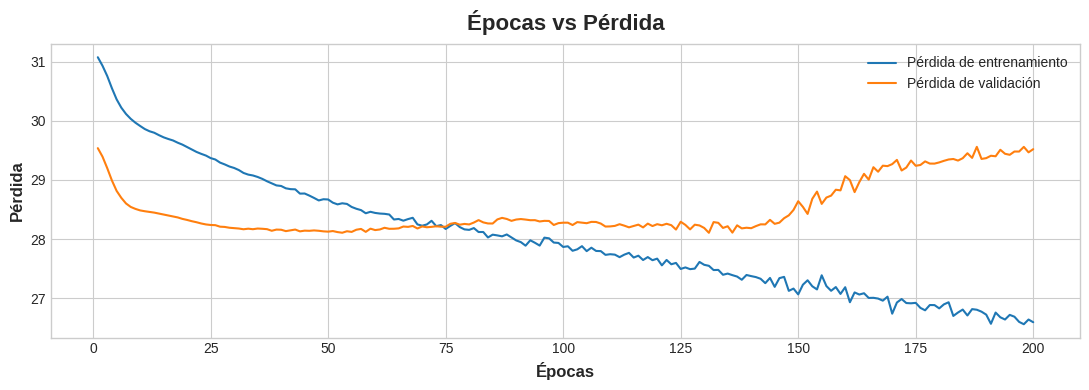

In [ ]:
# Extraer la pérdida del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfica Épocas vs Pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Pérdida de entrenamiento')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Épocas vs Pérdida')
plt.show()

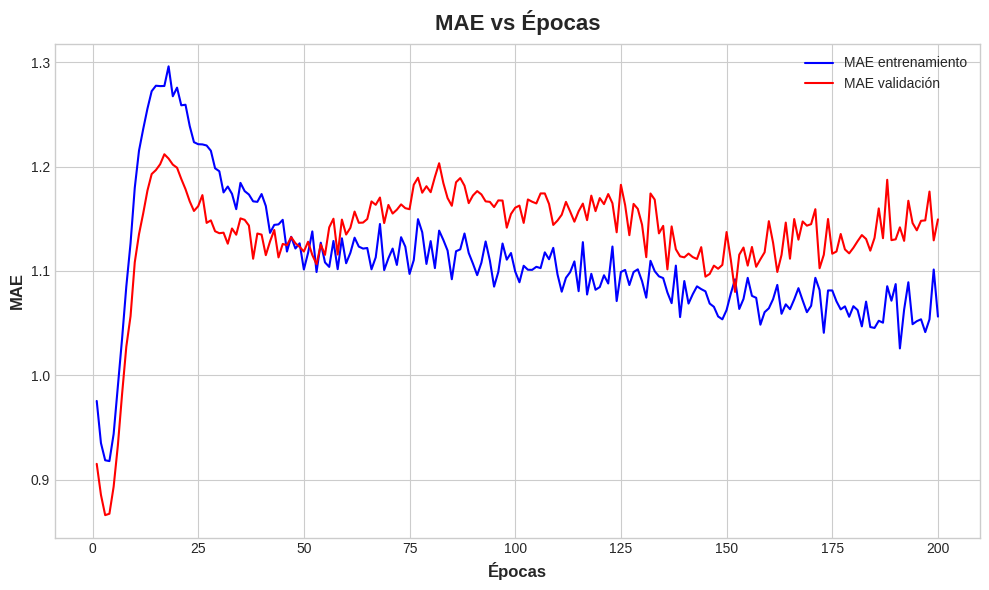

In [ ]:
# Obtén los valores del MAE tanto para los datos de entrenamiento como para los de validación
mae = history.history['mae']
val_mae = history.history['val_mae']

# Crea un rango de épocas para el eje X
epochs = range(1, len(mae) + 1)

# Grafica el MAE para entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'b', label='MAE entrenamiento')
plt.plot(epochs, val_mae, 'r', label='MAE validación')
plt.title('MAE vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

### Comparativa

Para poder comparar los modelos se necesita elegir una métrica de desempeño con la cual se evaluará cada uno de los modelo. En este caso se usará como métrica de desempeño el error absoluto medio porcentual (MAPE), el cual se define por la siguiente expresión:

\begin{align}
        MAPE = \frac{1}{n} \sum_{i=1} ^{n} \frac{\mid y_i - \hat{y_i} \mid}{\mid y_i \mid}
    \end{align}

Donde:
- $n$ es el número de datos en el set
- $y_i$ es el valor real de la observación (targets)
- $\hat{y_i}$ es el valor predicho de la observación

Un MAPE cercano a cero indica que el modelo realiza buenas predicciones, que se acercan mucho a los targets.

En la siguiente función se define la funcion "mape", la cual recibe como entrada los targets y las predicciones del modelo. Como su nombre lo indica, la función devuelve el MAPE.

In [ ]:
def mape(y_true, y_pred):
    # Evitar la división por cero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true, y_pred = y_true[non_zero_indices], y_pred[non_zero_indices]

    # Calcular MAPE y multiplicar por 100 para obtener el porcentaje
    mape_value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return round(mape_value, 2)

Graficamos la diferencia de error

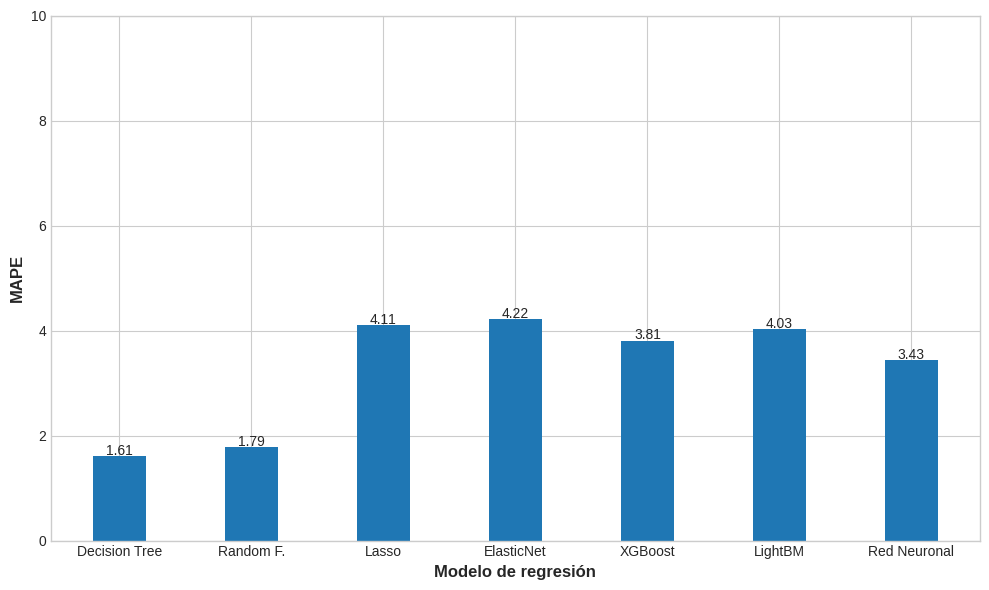

In [ ]:
import matplotlib.pyplot as plt

# Calcular los mape del baseline, el arbol de decision y el Gradient Boosting
dt_mape = mape(y_test, y_pred_test_DT)
rf_mape = mape(y_test, y_pred_test_RF)
lasso_mape = mape(y_test, y_pred_test_Lasso)
elastic_mape = mape(y_test, y_pred_test_elasticnet)
xgb_mape = mape(y_test, y_pred_test_xgb)
lgb_mape = mape(y_test, y_pred_test_lgb)
rnn_mape = mape(y_test, y_pred_test_RNN)

# Graficar los mape
fig, ax = plt.subplots(figsize=(10, 6))  # Ajustar tamaño de la figura
x = ['Decision Tree', 'Random F.', 'Lasso', 'ElasticNet', 'XGBoost', 'LightBM', 'Red Neuronal']
y_ = [dt_mape, rf_mape, lasso_mape, elastic_mape, xgb_mape, lgb_mape, rnn_mape]

ax.bar(x, y_, width=0.4)
ax.set_xlabel('Modelo de regresión')
ax.set_ylabel('MAPE')
ax.set_ylim(0, 10)

# Agregar el MAPE a la gráfica
for index, value in enumerate(y_):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')

plt.tight_layout()
plt.show()

### Ponderación de éxito

In [ ]:
# Obtener las ponderaciones (coeficientes) del mejor, que es el de
ponderaciones = model_DT.feature_importances_
resultado = data.copy()

# Crear un DataFrame con las ponderaciones
ponderaciones_df = pd.DataFrame({
    'Variable': X.columns,
    'Ponderacion': ponderaciones
})

resultado['ponderado'] = X.apply(lambda row: sum(row * ponderaciones), axis=1)

# Calcular el porcentaje de éxito
resultado['% Éxito'] = 100 * (resultado['ponderado'] - resultado['ponderado'].min()) / (resultado['ponderado'].max() - resultado['ponderado'].min())

Muestra_final = pd.merge(Social, Edo_Mun_Keys, on=["Clave Municipio", "Clave Estado"], how='left')

# Agregar la columna '% Éxito' a los datos originales
Muestra_final['% Éxito'] = resultado['% Éxito']

Muestra_final.head()

## Enfoque Global

Procedemos ahora a analizar cada uno de los modelos y compararlo con los diferentes métodos de ingeniería de características y graficamos:

### Resultados

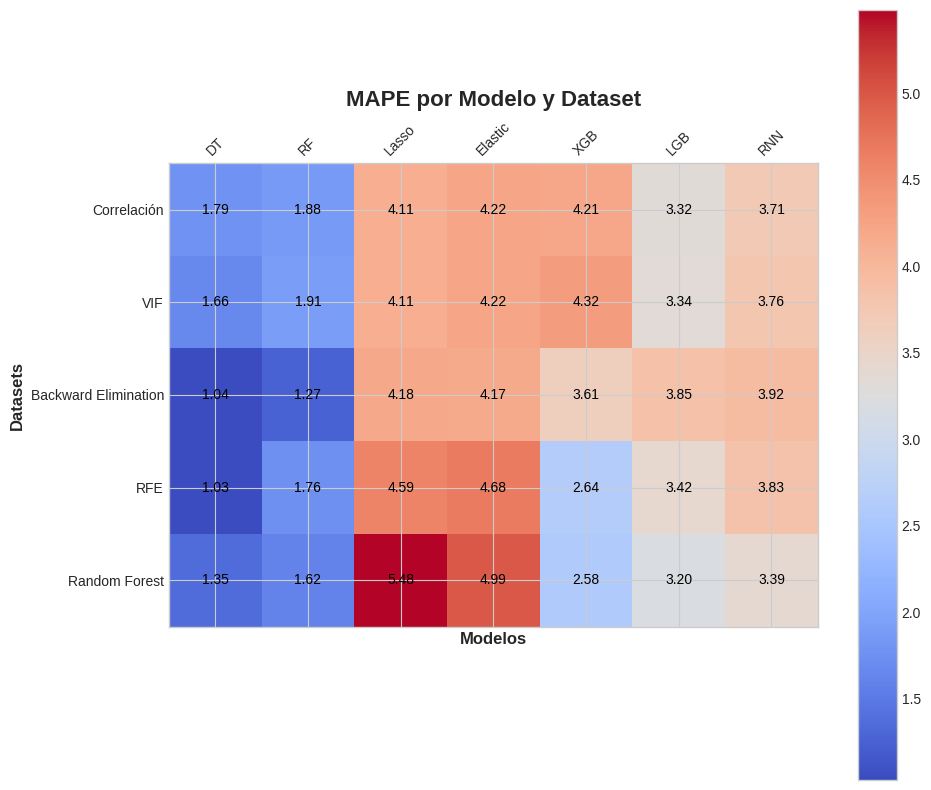

In [ ]:
data = Comparativa_por_Dataset
# Nombres de los modelos
model_names = ['DT', 'RF', 'Lasso', 'Elastic', 'XGB', 'LGB', 'RNN']
dataset_names = ['Correlación', 'VIF', 'Backward Elimination', 'RFE', 'Random Forest']

# Configuración de la figura
fig, ax = plt.subplots(figsize=(10, 8))

# Creación de la cuadrícula
cax = ax.matshow(data, cmap='coolwarm')

# Añadir la barra de color
fig.colorbar(cax)

# Establecer etiquetas en los ejes
ax.set_xticks(np.arange(len(model_names)))
ax.set_yticks(np.arange(len(dataset_names)))

ax.set_xticklabels(model_names)
ax.set_yticklabels(dataset_names)

# Rotar etiquetas de los modelos para mejor visibilidad
plt.xticks(rotation=45)

# Añadir valores en las celdas
for i in range(len(dataset_names)):
    for j in range(len(model_names)):
        ax.text(j, i, f'{data[i][j]:.2f}', ha='center', va='center', color='black')

# Título y etiquetas de los ejes
plt.title('MAPE por Modelo y Dataset')
ax.set_xlabel('Modelos')
ax.set_ylabel('Datasets')

# Mostrar el gráfico
plt.show()

El mejor modelo en practicamente todos los casos fue el **Decision tree**, aunque bien, la red neuronal no se ha quedado muy atrás y puede robustecerse. Y en cuanto a la selección de características, el mejor valor fue el de la selección de características por **RFE (recursive feature elimination)**

Procedemos a usar éste modelo y selección de características para la ponmderación final.

In [ ]:
Columnas_relevantes = selected_features_rfe

#Dataset_Total = BDD_Municipal_Elim[['Clave Estado', 'Clave Municipio'] + Columnas_relevantes]
Dataset_Total = BDD_Municipal_Elim[Columnas_relevantes]
Dataset_Total.head(-5)

Hacemos la ponderación según el modelo elegido

## Global con clusterización

Vamos a clusterizar nuestros datos para luego reentrenar el modelo, ésto debido a poder comparar mercados similares y no tener puntos abismalmente separados.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

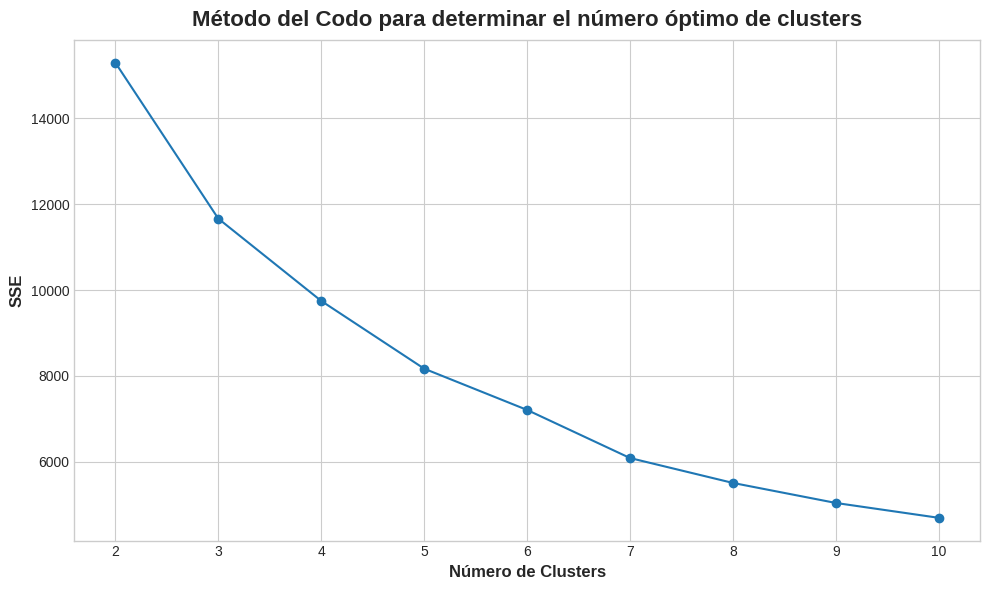

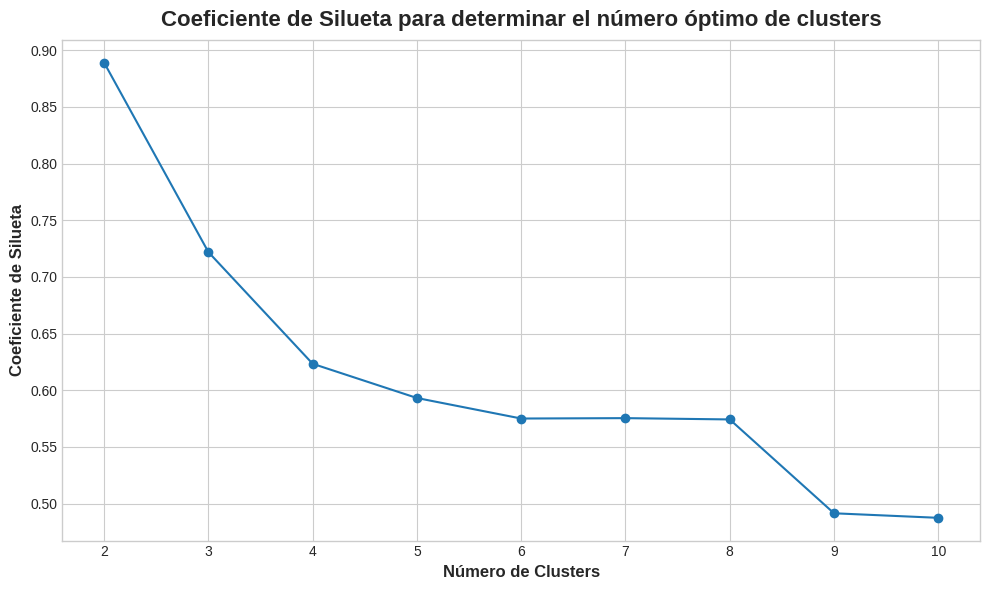

In [ ]:
# Suponiendo que ya tienes los datos cargados en un DataFrame 'df'
#df = Dataset_Total.drop(['Estado', 'Municipio'], axis=1)
df = Dataset_Total.copy()

# Preparar los datos para la clusterización (normalización)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)  # Normalizar todas las características excepto las claves

# Encontrar el número óptimo de clusters utilizando el método del codo
sse = []
silhouette_scores = []
max_clusters = 10  # Suponemos un máximo de 10 clusters para evaluar

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)  # Sum of Squared Errors (SSE)
    if k > 1:
        silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), sse, marker='o')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.xticks(np.arange(2, max_clusters + 1))
plt.grid(True)
plt.show()

# Graficar el coeficiente de silueta
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta para determinar el número óptimo de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(np.arange(2, max_clusters + 1))
plt.grid(True)
plt.show()


In [ ]:
# Basándonos en los resultados del método del codo y el coeficiente de silueta, seleccionamos un número de clusters
# Por ejemplo, si el método del codo muestra un cambio significativo en el SSE y el coeficiente de silueta es alto,
# elegiremos ese número de clusters para el siguiente paso.

# Por simplicidad, supongamos que elegimos 3 clusters basándonos en la visualización y evaluación de las gráficas.

# Realizar la clusterización final con el número elegido de clusters
final_k = 3
kmeans_final = KMeans(n_clusters=final_k, random_state=42)
kmeans_final.fit(scaled_data)

# Agregar los resultados de la clusterización al DataFrame original
df['Cluster'] = kmeans_final.labels_

# Identificar los estados que conforman cada cluster
df = pd.concat([df, Edo_Mun_Keys], axis=1)
cluster_states = df.groupby('Cluster')['Clave Estado'].unique()

df_names = Edo_Mun_Keys

# Mostrar los nombres de estados por cada cluster
for cluster, states in cluster_states.items():
    state_names = df_names[df_names['Clave Estado'].isin(states)]['Estado'].unique()
    print(f"Cluster {cluster}: Estados {state_names}")


###### Reducción dimensional con PCA

###### 2 dimensiones

Para tener una visualización de los clusters, hacemos una transformación en la dimensionalidad a 2 componentes principales para graficar los clusters como colores en un plano.

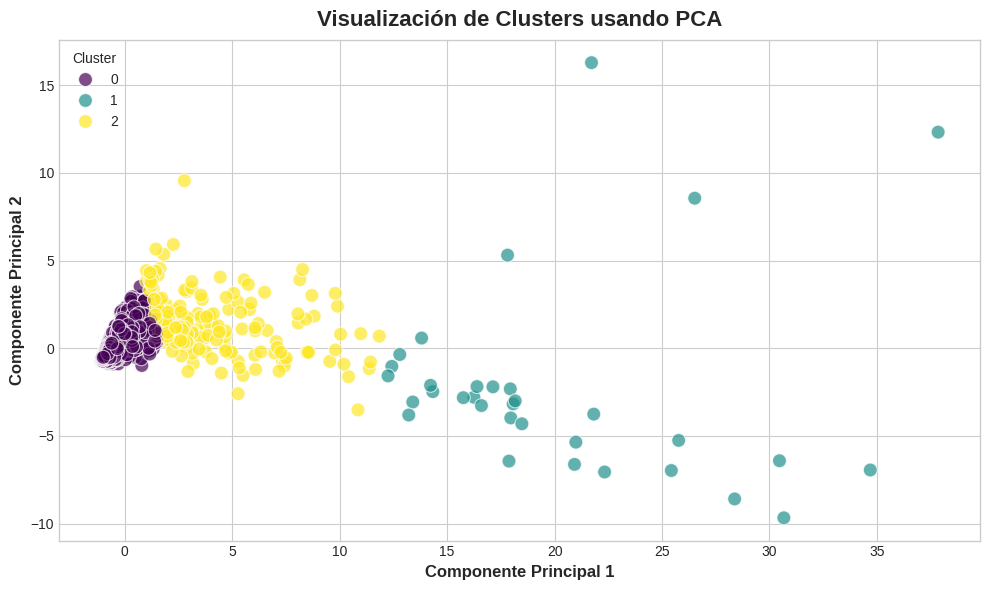

In [ ]:
# Realizar PCA para reducir la dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Convertir los componentes principales a un DataFrame para facilitar la visualización
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_final.labels_

# Graficar los resultados usando seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Visualización de Clusters usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [ ]:
# Mostrar la varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por el primer componente principal: {explained_variance[0]:.2f}")
print(f"Varianza explicada por el segundo componente principal: {explained_variance[1]:.2f}")

Varianza explicada por el primer componente principal: 0.69
Varianza explicada por el segundo componente principal: 0.10


###### 3 dimensiones

Para tener una visualización de los clusters, hacemos una transformación en la dimensionalidad a 2 componentes principales para graficar los clusters como colores en un plano.

In [ ]:
# Realizar PCA para reducir la dimensionalidad a 3 componentes principales
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Convertir los componentes principales a un DataFrame para facilitar la visualización
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = kmeans_final.labels_

# Graficar los resultados en 3D
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title='Visualización de Clusters usando PCA (3 Componentes)',
                    labels={'PC1': 'Componente Principal 1', 'PC2': 'Componente Principal 2', 'PC3': 'Componente Principal 3'})
fig.show()

In [ ]:
# Mostrar la varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por el primer componente principal: {explained_variance[0]:.2f}")
print(f"Varianza explicada por el segundo componente principal: {explained_variance[1]:.2f}")
print(f"Varianza explicada por el tercer componente principal: {explained_variance[2]:.2f}")

Varianza explicada por el primer componente principal: 0.69
Varianza explicada por el segundo componente principal: 0.10
Varianza explicada por el tercer componente principal: 0.06


Lo ultimo que nos queda por hacer es considerar la clusterización para rehacer el entrenamiento y reasignar las calificaciones. Una vez hecho ésto es que se descargan los valores para ver los resultados en un BI Dashboard. En el repositorio de github donde se encontró ésta libreta es que aparecen capturas del dashboard generado.